In [52]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

### 1. Load data and initial inspection

In [12]:
df = pd.read_csv(r"RUS_combined_data.csv")
df.head()   

,Unnamed: 0,id,car_brand,car_model,violation_date,crossroad_name,violation_protocol_name,violation_ammount
0,0,35648046,TOYOTA,SEQUOIA,1/1/2020 0:03,А/д Бишкек - Торугарт. г. Кемин. 102 км.,Превышение установленной скорости движения на ...,3000
1,1,35648049,MITSUBISHI,COLT,1/1/2020 0:06,"А/д Бишкек - Аэропорт «Манас». АЗС Ак-Жол, 23 км",Превышение установленной скорости движения на ...,3000
2,2,35648071,HYUNDAI,ELANTRA,1/1/2020 0:20,"А/д Биш. Торугарт, 20км., с. Люксембург",Превышение установленной скорости движения на ...,3000
3,3,35648091,MERCEDES-BENZ,SPRINTER 311,1/1/2020 0:15,"г. Бишкек, пересечение пр. Чуй - ул. Ю.Абдрахм...",Невыполнение требований ПДД об остановке перед...,1000
4,4,35648093,MERCEDES-BENZ,E 240,1/1/2020 0:17,"г. Бишкек, пересечение ул. Ю.Абдрахманова - ул...",Невыполнение требований ПДД об остановке перед...,1000


In [13]:
if "Unnamed: 0" in df.columns:
    print('Дропнул эксель колонну, так как она не нужна жиги')
    df = df.drop(columns=["Unnamed: 0"])
df.info()

Дропнул эксель колонну, так как она не нужна жиги
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354392 entries, 0 to 2354391
Data columns (total 7 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   id                       int64 
 1   car_brand                object
 2   car_model                object
 3   violation_date           object
 4   crossroad_name           object
 5   violation_protocol_name  object
 6   violation_ammount        int64 
dtypes: int64(2), object(5)
memory usage: 125.7+ MB


In [14]:
df.isnull().sum()
df.shape

(2354392, 7)

In [15]:
df = df.dropna()
df.shape

(2354369, 7)

In [16]:
print('Чекаем являются ли эти колонки уникалными')
df.nunique()

Чекаем являются ли эти колонки уникалными


id                         1915019
car_brand                      242
car_model                     3194
violation_date             1978515
crossroad_name                 552
violation_protocol_name         20
violation_ammount                4
dtype: int64

In [17]:
if df["id"].is_unique:
    print("id уникален, всё ок")
else:
    print("id НЕ уникален, есть дубликаты")
total_rows = len(df)
unique_ids = df["id"].nunique()

print("Всего строк:", total_rows)
print("Уникальных id:", unique_ids)

id НЕ уникален, есть дубликаты
Всего строк: 2354369
Уникальных id: 1915019


In [18]:
dup_ids = df.loc[df["id"].duplicated(), "id"]
dup_ids.head()

256337    206208
256342     91231
256350     38233
256359     63396
256379    167667
Name: id, dtype: int64

In [19]:
print('Хочу выяснить сфигали они не уникальны')
print('Как будто тут один и тот же человек нарушает или машина')
df[df["id"] == 38233]

Хочу выяснить сфигали они не уникальны
Как будто тут один и тот же человек нарушает или машина


,id,car_brand,car_model,violation_date,crossroad_name,violation_protocol_name,violation_ammount
256349,38233,HONDA,FIT,2019-03-04 01:16:21.000,"А/д Бишкек –Торугарт 10,3км","Нарушение «превышение скорости» свыше 20 км/ч,...",3000
256350,38233,HONDA,FIT,2019-03-04 01:18:20.000,А/д Бишкек - Торугарт 12.9км,"Нарушение «превышение скорости» свыше 20 км/ч,...",3000
282567,38233,HONDA,FIT,2019-03-21 03:34:27.000,"А/д Бишкек –Торугарт 10,3км","Нарушение «превышение скорости» свыше 20 км/ч,...",3000
328861,38233,HONDA,FIT,2019-04-19 08:08:53.000,г. Бишкек ул.Ж.Жолу д.291,"Нарушение «превышение скорости» свыше 10 км/ч,...",1000


In [20]:
print('Количество строк где все колонны похожие:', df.duplicated().sum())
print('Дропаю только эти абсолютно похожие строки')
df.drop_duplicates(inplace=True)
print('Shape of df', df.shape)

Количество строк где все колонны похожие: 130725
Дропаю только эти абсолютно похожие строки
Shape of df (2223644, 7)


In [21]:
df.head()

,id,car_brand,car_model,violation_date,crossroad_name,violation_protocol_name,violation_ammount
0,35648046,TOYOTA,SEQUOIA,1/1/2020 0:03,А/д Бишкек - Торугарт. г. Кемин. 102 км.,Превышение установленной скорости движения на ...,3000
1,35648049,MITSUBISHI,COLT,1/1/2020 0:06,"А/д Бишкек - Аэропорт «Манас». АЗС Ак-Жол, 23 км",Превышение установленной скорости движения на ...,3000
2,35648071,HYUNDAI,ELANTRA,1/1/2020 0:20,"А/д Биш. Торугарт, 20км., с. Люксембург",Превышение установленной скорости движения на ...,3000
3,35648091,MERCEDES-BENZ,SPRINTER 311,1/1/2020 0:15,"г. Бишкек, пересечение пр. Чуй - ул. Ю.Абдрахм...",Невыполнение требований ПДД об остановке перед...,1000
4,35648093,MERCEDES-BENZ,E 240,1/1/2020 0:17,"г. Бишкек, пересечение ул. Ю.Абдрахманова - ул...",Невыполнение требований ПДД об остановке перед...,1000


In [22]:
print('Видим что формат дат такая фигня')
df["violation_date"].astype(str).value_counts().sample(100)
    

Видим что формат дат такая фигня


violation_date
10/08/2020 06:27:22        1
2019-03-13 15:25:31.000    1
13/11/2019 08:17:03        1
19/03/2021 15:18:09        1
01/09/2019 16:02:50        2
                          ..
24/02/2020 00:12:29        1
24/01/2021 16:28:09        1
28/10/2020 03:29:33        1
17/11/2020 13:42:37        1
30/10/2020 15:13:47        1
Name: count, Length: 100, dtype: int64

In [23]:
df[df['violation_date'] == '51:00.0']

,id,car_brand,car_model,violation_date,crossroad_name,violation_protocol_name,violation_ammount
1303318,149640,MERCEDES-BENZ,200E,51:00.0,"г. Бишкек, пересечение пр. Чуй - ул. И.Павлова",Невыполнение требований ПДД об остановке перед...,3000
1303646,156077,BMW,X6,51:00.0,г.Бишкек Путепровод по ул.Ибраимова,"Нарушение «превышение скорости» свыше 10 км/ч,...",1000
1304679,12528,HONDA,FIT,51:00.0,"г.Бишкек, ул. Масалиева д. 49","Нарушение «превышение скорости» свыше 10 км/ч,...",1000
1312166,102797,MERCEDES-BENZ,SPRINTER 313,51:00.0,"г. Бишкек, пересечение ул. Ю.Абдрахманова - ул...",Невыполнение требований ПДД об остановке перед...,3000
1312904,190636,TOYOTA,IST,51:00.0,"г. Бишкек, пересечение пр. Жибек Жолу – ул. Ку...",Невыполнение требований дорожных знаков,3000
1313993,84931,AUDI,A6,51:00.0,"А/д Бишкек –Торугарт 10,3км","Нарушение «превышение скорости» свыше 10 км/ч,...",1000
1314894,168554,NISSAN,CEFIRO,51:00.0,г.Бишкек Путепровод по ул. 7-Апреля,"Нарушение «превышение скорости» свыше 20 км/ч,...",3000
1317497,29600,NISSAN,PATROL,51:00.0,"г. Бишкек, путепровод по пр. Байтик Баатыра","Нарушение «превышение скорости» свыше 10 км/ч,...",1000
1321645,1303,TOYOTA,IST,51:00.0,"г. Бишкек, ж.м. Арча-Бешик ул. Садырбаева № 371/2","Нарушение «превышение скорости» свыше 10 км/ч,...",1000
1323153,205140,LEXUS,GX 470,51:00.0,"г. Бишкек, пересечение пр. Чуй - ул. Ю.Фучика",Невыполнение требований ПДД об остановке перед...,3000


In [24]:
df[['raw_date', 'raw_time']] = (
    df['violation_date']
    .astype(str)
    .str.split(' ', n=1, expand=True)
)
print('raw_time is null', df['raw_time'].isnull().sum(), 'shape=', df.shape)
df.sample(50)

raw_time is null 134560 shape= (2223644, 9)


,id,car_brand,car_model,violation_date,crossroad_name,violation_protocol_name,violation_ammount,raw_date,raw_time
116196,38576391,MAZDA,DEMIO,30/01/2021 12:47:01,"г. Бишкек, пересечение ул. А.Суеркулова - ул. ...",Нарушение требований разметки проезжей части д...,1000,30/01/2021,12:47:01
1049014,37151722,HYUNDAI,PORTER,23/06/2020 19:00:18,"г. Бишкек, пересечение пр. Дэн Сяопина - ул. Ж...","Проезд на запрещенный сигнал светофора, либо ж...",3000,23/06/2020,19:00:18
699306,118152,TOYOTA,LAND CRUISER 200,2019-05-14 17:23:41.000,А/д Бишкек – Торугарт. (объездная). 58км,"Нарушение «превышение скорости» свыше 20 км/ч,...",3000,2019-05-14,17:23:41.000
1570446,37664829,HONDA,FIT,31/08/2020 07:22:53,"г. Бишкек, пересечение ул. Ю.Абдрахманова - ул...",Нарушение требований разметки проезжей части д...,1000,31/08/2020,07:22:53
1053581,37163771,LEXUS,LS 460,24/06/2020 15:28:59,"Объездная а/д. ""Бишкек-Нарын-Торугарт"" - 44,30...",Превышение установленной скорости движения на ...,1000,24/06/2020,15:28:59
398284,36224862,TOYOTA,CAMRY,08/03/2020 16:18:28,г. Бишкек ж.м. Ак-Орго ул. Барпы-Алыкулова № 6...,Превышение установленной скорости движения на ...,1000,08/03/2020,16:18:28
1483311,37495423,TOYOTA,CAMRY,10/08/2020 14:52:11,"г. Бишкек, пересечение просп. Жибек-Жолу и бул...",Невыполнение требований дорожных знаков,1000,10/08/2020,14:52:11
1655516,34857022,LEXUS,GX460,18/09/2019 16:49:16,"А/д Бишкек – Торугарт, 18,8км., с. Люксембург",Превышение установленной скорости движения на ...,1000,18/09/2019,16:49:16
2307975,38350050,HONDA,FIT,08/12/2020 16:13:50,"г. Бишкек, пересечение пр. Чуй - ул. Б.Бейшена...",Нарушение требований разметки проезжей части д...,1000,08/12/2020,16:13:50
150509,35910606,HONDA,FIT,14/02/2020 13:49:00,"г. Бишкек, пересечение ул. А.Суеркулова - ул. ...",Невыполнение требований дорожных знаков,1000,14/02/2020,13:49:00


In [25]:
df.dropna(subset=['raw_time'], inplace=True)
df.shape

(2089084, 9)

In [26]:
df["raw_date"] = df["raw_date"].astype(str).str.strip()

In [27]:
s = df["raw_date"].astype(str).str.strip()

mask_dash = s.str.fullmatch(r"\d{4}-\d{2}-\d{2}")

mask_slash = s.str.fullmatch(r"\d{1,2}/\d{1,2}/\d{4}")

norm_dt = pd.Series(pd.NaT, index=df.index, dtype="datetime64[ns]")

norm_dt[mask_dash] = pd.to_datetime(
    s[mask_dash],
    format="%Y-%m-%d",
    errors="coerce"
)

norm_dt[mask_slash] = pd.to_datetime(
    s[mask_slash],
    format="%d/%m/%Y",
    errors="coerce"
)

df["normalized_date"] = norm_dt

print("Всего строк:", len(df))
print("Не распарсилось:", df["normalized_date"].isna().sum())
df[["raw_date", "normalized_date"]].sample(200)


Всего строк: 2089084
Не распарсилось: 0


,raw_date,normalized_date
2128098,23/11/2019,2019-11-23
66008,21/01/2020,2020-01-21
849215,2019-06-01,2019-06-01
924311,2019-06-22,2019-06-22
179337,24/02/2020,2020-02-24
...,...,...
604266,02/04/2021,2021-04-02
765101,12/05/2020,2020-05-12
2296254,02/12/2020,2020-12-02
602382,01/04/2021,2021-04-01


In [28]:
df['normalized_time'] = pd.to_datetime(df['raw_time'], errors='coerce').dt.time

C:\Users\Abay\AppData\Local\Temp\ipykernel_20572\2202367266.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['normalized_time'] = pd.to_datetime(df['raw_time'], errors='coerce').dt.time


In [29]:
print(df.shape)
df.sample(100)

(2089084, 11)


,id,car_brand,car_model,violation_date,crossroad_name,violation_protocol_name,violation_ammount,raw_date,raw_time,normalized_date,normalized_time
1723688,37712460,AUDI,A4,05/09/2020 14:44:49,г.Бишкек Путепровод по ул.Ибраимова,Превышение установленной скорости движения на ...,1000,05/09/2020,14:44:49,2020-09-05,14:44:49
2132148,35428303,MERCEDES-BENZ,SPRINTER,24/11/2019 14:11:15,"Ысык-Атинский р-он, Объездная а/дорога ""Бишкек...",Превышение установленной скорости движения на ...,1000,24/11/2019,14:11:15,2019-11-24,14:11:15
1606870,34736705,TOYOTA,IST,07/09/2019 12:35:50,"г. Бишкек, пересечение пр. Жибек Жолу - ул. М....",Невыполнение требований ПДД об остановке перед...,1000,07/09/2019,12:35:50,2019-09-07,12:35:50
2104042,35361409,MERCEDES-BENZ,230,16/11/2019 23:03:39,"А/д.Бишкек - Чалдовар. 67,3км., с.Вознесеновка",Превышение установленной скорости движения на ...,1000,16/11/2019,23:03:39,2019-11-16,23:03:39
113687,38571702,HONDA,STEPWGN,29/01/2021 14:25:38,"г. Бишкек, пересечение ул. Ю.Абдрахманова - ул...",Невыполнение требований дорожных знаков,1000,29/01/2021,14:25:38,2021-01-29,14:25:38
...,...,...,...,...,...,...,...,...,...,...,...
1762890,37796331,HONDA,STEPWGN,16/09/2020 09:24:15,"г. Бишкек, пересечение бульв. Молодой Гвардии ...",Нарушение требований разметки проезжей части д...,1000,16/09/2020,09:24:15,2020-09-16,09:24:15
400564,36227142,MERCEDES-BENZ,200E,08/03/2020 15:58:54,г. Бишкек ж.м. Ак-Орго ул. Барпы-Алыкулова № 6...,Превышение установленной скорости движения на ...,1000,08/03/2020,15:58:54,2020-03-08,15:58:54
1095043,204680,MERCEDES-BENZ,E 230,2019-07-07 09:12:27.000,А/д.Бишкек - Торугарт. г. Токмок 59 км.,"Нарушение «превышение скорости» свыше 10 км/ч,...",1000,2019-07-07,09:12:27.000,2019-07-07,09:12:27
250430,38683339,HONDA,CR-V,26/02/2021 09:19:54,"Кеминский р-он. с. Ак-Бекет, основная а/д ""Биш...",Превышение установленной скорости движения на ...,3000,26/02/2021,09:19:54,2021-02-26,09:19:54


In [30]:
df["year"] = df["normalized_date"].dt.year
df["month"] = df["normalized_date"].dt.month
df["day"] = df["normalized_date"].dt.day
df["hour"] = pd.to_datetime(df["raw_time"], errors="coerce").dt.hour
df["weekday"] = df["normalized_date"].dt.dayofweek
weekday_map = {
    0: "Mon", 1: "Tue", 2: "Wed", 
    3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"
}
print('По дням недели распределил, dayofweek офигенная функция')
df["weekday_name"] = df["weekday"].map(weekday_map)
df.drop(columns=['violation_date'], inplace=True)
df.sample(10)

C:\Users\Abay\AppData\Local\Temp\ipykernel_20572\4196713491.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["hour"] = pd.to_datetime(df["raw_time"], errors="coerce").dt.hour


По дням недели распределил, dayofweek офигенная функция


,id,car_brand,car_model,crossroad_name,violation_protocol_name,violation_ammount,raw_date,raw_time,normalized_date,normalized_time,year,month,day,hour,weekday,weekday_name
483210,38718540,MERCEDES-BENZ,S 500,"г. Бишкек, пересечение пр. Чуй - ул. Курманжан...",Нарушение требований разметки проезжей части д...,1000,05/03/2021,17:09:37,2021-03-05,17:09:37,2021,3,5,17,4,Fri
2043910,38151358,HYUNDAI,PORTER,"г. Бишкек, пересечение пр. Жибек Жолу - ул. Фу...",Невыполнение требований дорожных знаков,1000,30/10/2020,15:11:52,2020-10-30,15:11:52,2020,10,30,15,4,Fri
2117889,35394868,HONDA,STEPWGN,"Московский р-он, с. Ак-Торпок а/дорога ""Петров...",Превышение установленной скорости движения на ...,3000,20/11/2019,15:05:30,2019-11-20,15:05:30,2019,11,20,15,2,Wed
525116,38807358,MITSUBISHI,CARISMA,"г. Бишкек, пересечение улиц Б.Алыкулова – М.Ом...",Превышение установленной скорости движения на ...,1000,24/03/2021,00:03:27,2021-03-24,00:03:27,2021,3,24,0,2,Wed
761103,36697985,HONDA,CIVIC,"г. Бишкек, пересечение улиц Айтматова – Масалиева",Нарушение требований разметки проезжей части д...,1000,11/05/2020,07:32:05,2020-05-11,07:32:05,2020,5,11,7,0,Mon
505495,38766675,HONDA,STEPWGN,"г. Бишкек, пересечение улиц Л.Толстого - Молод...",Невыполнение требований ПДД об остановке перед...,1000,15/03/2021,14:59:18,2021-03-15,14:59:18,2021,3,15,14,0,Mon
582287,36588367,MERCEDES-BENZ,200,"А/д Бишкек - Аэропорт «Манас» с. Достук. 10,2 км.",Превышение установленной скорости движения на ...,1000,21/04/2020,07:21:03,2020-04-21,07:21:03,2020,4,21,7,1,Tue
2318796,38372164,MERCEDES-BENZ,200,"Чуйский р-он. с. Жаны-Чек, основная а/д ""Бишке...",Превышение установленной скорости движения на ...,1000,13/12/2020,16:33:06,2020-12-13,16:33:06,2020,12,13,16,6,Sun
1149911,148497,MERCEDES-BENZ,E 320,"г. Бишкек, пересечение ул. А.Суеркулова - ул. ...",Невыполнение требований дорожных знаков,3000,2019-07-20,02:08:37.000,2019-07-20,02:08:37,2019,7,20,2,5,Sat
439041,36371866,HONDA,ODYSSEY,Основная автодорога Бишкек - Торугарт 12.9км,Превышение установленной скорости движения на ...,1000,23/03/2020,08:44:42,2020-03-23,08:44:42,2020,3,23,8,0,Mon


In [31]:
crossroad_coords_bish = {
    "г. Бишкек ул. Жибек-Жолу № 291. ": {
        "latitude": 42.886356,
        "longitude": 74.625874,
    },
    "г.Бишкек, Путепровод по ул.Шабдан-Баатыра (ул.7-Апреля)": {
        "latitude": 42.867031,
        "longitude": 74.636661,
    },
    "г. Бишкек, пересечение бульв. Молодой Гвардии и ул. Ж.Боконбаева": {
        "latitude": 42.868335,
        "longitude": 74.575132,
    },
    "г. Бишкек, пересечение просп. Жибек-Жолу и бульв. Молодой Гвардии": {
        "latitude": 42.884736,
        "longitude": 74.576391,
    },
    "г. Бишкек, пересечение улиц Л.Толстого - Молодая Гвардия": {
        "latitude": 42.866329,
        "longitude": 74.574666,
    },
    "г. Бишкек, путепровод по пр. Манаса": {
        "latitude": 42.866261,
        "longitude": 74.587268,
    },
    "г. Бишкек, пересечение пр. Чуй - бул. Молодой Гвардии": {
        "latitude": 42.877192,
        "longitude": 74.575236,
    },
    "г. Бишкек, пересечение пр. Дэн Сяопина - ул. Ж.Садыгалиева": {
        "latitude": 42.87428,
        "longitude": 74.523351,
    },
    "г. Бишкек, пересечение улиц Чуй - Шопокова": {
        "latitude": 42.875553,
        "longitude": 74.615181,
    },
    "г. Бишкек, пересечение ул. А.Суеркулова - ул. Б.Юнусалиева": {
        "latitude": 42.835588,
        "longitude": 74.622127,
    },
    "г. Бишкек, пересечение пр. Чуй - ул. Курманжан Датки": {
        "latitude": 42.875314, 
        "longitude": 74.636828, 
    }, 
    "г. Бишкек, путепровод по пр. Байтик Баатыра": {
       "latitude": 42.860289, 
        "longitude": 74.610614, 
    },
    "г. Бишкек, пересечение улиц М.Горького – Ч.Айтматова": {
       "latitude": 42.857565, 
       "longitude": 74.586835,        
    },
    "г. Бишкек, пересечение ул. Ю.Абдрахманова - ул. Московская": {
       "latitude": 42.869296, 
       "longitude": 74.611266,        
    },
    "г. Бишкек, пересечение пр. Чуй - ул. Б.Бейшеналиевой":{
       "latitude": 42.877325, 
       "longitude": 74.571789,        
    },
    "г. Бишкек, пересечение пр. Дэн Сяопина - ул. Б.Алыкулова":{
       "latitude": 42.874156, 
       "longitude": 74.508667,  
    },
    "г. Бишкек, пересечение ул. Байтик Баатыра - ул. А.Суеркулова":{
       "latitude": 42.837584, 
       "longitude": 74.608235,  
    },
    "г. Бишкек, пересечение пр. Жибек Жолу – ул. Курманжан Датки":{
       "latitude": 42.888035, 
       "longitude": 74.635574,  
    },
    "г. Бишкек, пересечение пр. Ч.Айтматова - ул. И.Ахунбаева":{
       "latitude": 42.843549, 
       "longitude": 74.586042, 
    },
    "г. Бишкек, пересечение улиц Ахунбаева - Тыналиева":{
       "latitude": 42.843824, 
       "longitude": 74.568413,  
    }
    }


In [32]:
coords_df = (
    pd.DataFrame
    .from_dict(crossroad_coords_bish, orient='index')
    .reset_index()
    .rename(columns={'index': 'crossroad_name'})
)

df = df.merge(
    coords_df,
    on='crossroad_name',
    how='left'   
)

df

,id,car_brand,car_model,crossroad_name,violation_protocol_name,violation_ammount,raw_date,raw_time,normalized_date,normalized_time,year,month,day,hour,weekday,weekday_name,latitude,longitude
0,35648046,TOYOTA,SEQUOIA,А/д Бишкек - Торугарт. г. Кемин. 102 км.,Превышение установленной скорости движения на ...,3000,1/1/2020,0:03,2020-01-01,00:03:00,2020,1,1,0,2,Wed,NaN,NaN
1,35648049,MITSUBISHI,COLT,"А/д Бишкек - Аэропорт «Манас». АЗС Ак-Жол, 23 км",Превышение установленной скорости движения на ...,3000,1/1/2020,0:06,2020-01-01,00:06:00,2020,1,1,0,2,Wed,NaN,NaN
2,35648071,HYUNDAI,ELANTRA,"А/д Биш. Торугарт, 20км., с. Люксембург",Превышение установленной скорости движения на ...,3000,1/1/2020,0:20,2020-01-01,00:20:00,2020,1,1,0,2,Wed,NaN,NaN
3,35648091,MERCEDES-BENZ,SPRINTER 311,"г. Бишкек, пересечение пр. Чуй - ул. Ю.Абдрахм...",Невыполнение требований ПДД об остановке перед...,1000,1/1/2020,0:15,2020-01-01,00:15:00,2020,1,1,0,2,Wed,NaN,NaN
4,35648093,MERCEDES-BENZ,E 240,"г. Бишкек, пересечение ул. Ю.Абдрахманова - ул...",Невыполнение требований ПДД об остановке перед...,1000,1/1/2020,0:17,2020-01-01,00:17:00,2020,1,1,0,2,Wed,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2089079,38545338,HONDA,TORNEO,"Московский р-он. с. Мураке ул. Бегалиева № 7, ...",Превышение установленной скорости движения на ...,3000,30/12/2020,16:08:58,2020-12-30,16:08:58,2020,12,30,16,2,Wed,NaN,NaN
2089080,38545467,TOYOTA,IPSUM,"Московский р-он. с. Мураке ул. Бегалиева № 7, ...",Превышение установленной скорости движения на ...,3000,30/12/2020,10:34:57,2020-12-30,10:34:57,2020,12,30,10,2,Wed,NaN,NaN
2089081,38545816,NISSAN,X-TRAIL,"Московский р-он. с. Мураке ул. Бегалиева № 7, ...",Превышение установленной скорости движения на ...,3000,30/12/2020,14:49:52,2020-12-30,14:49:52,2020,12,30,14,2,Wed,NaN,NaN
2089082,38545837,BMW,X5,"Московский р-он. с. Мураке ул. Бегалиева № 7, ...",Превышение установленной скорости движения на ...,3000,22/12/2020,10:30:40,2020-12-22,10:30:40,2020,12,22,10,1,Tue,NaN,NaN


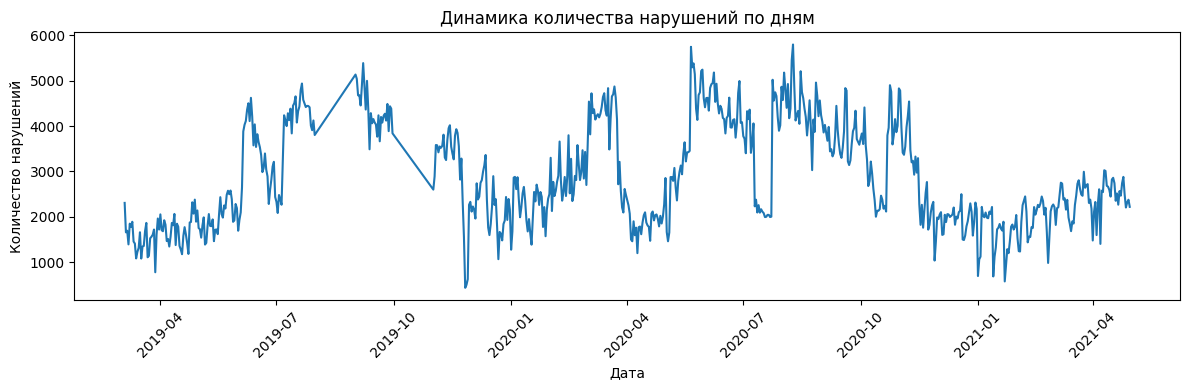

In [33]:
daily_counts = (
    df
    .groupby('normalized_date')   
    .size()                      
    .reset_index(name='n_violations')  
)
plt.figure(figsize=(12, 4))

plt.plot(
    daily_counts['normalized_date'],
    daily_counts['n_violations']
)

plt.xlabel('Дата')
plt.ylabel('Количество нарушений')
plt.title('Динамика количества нарушений по дням')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

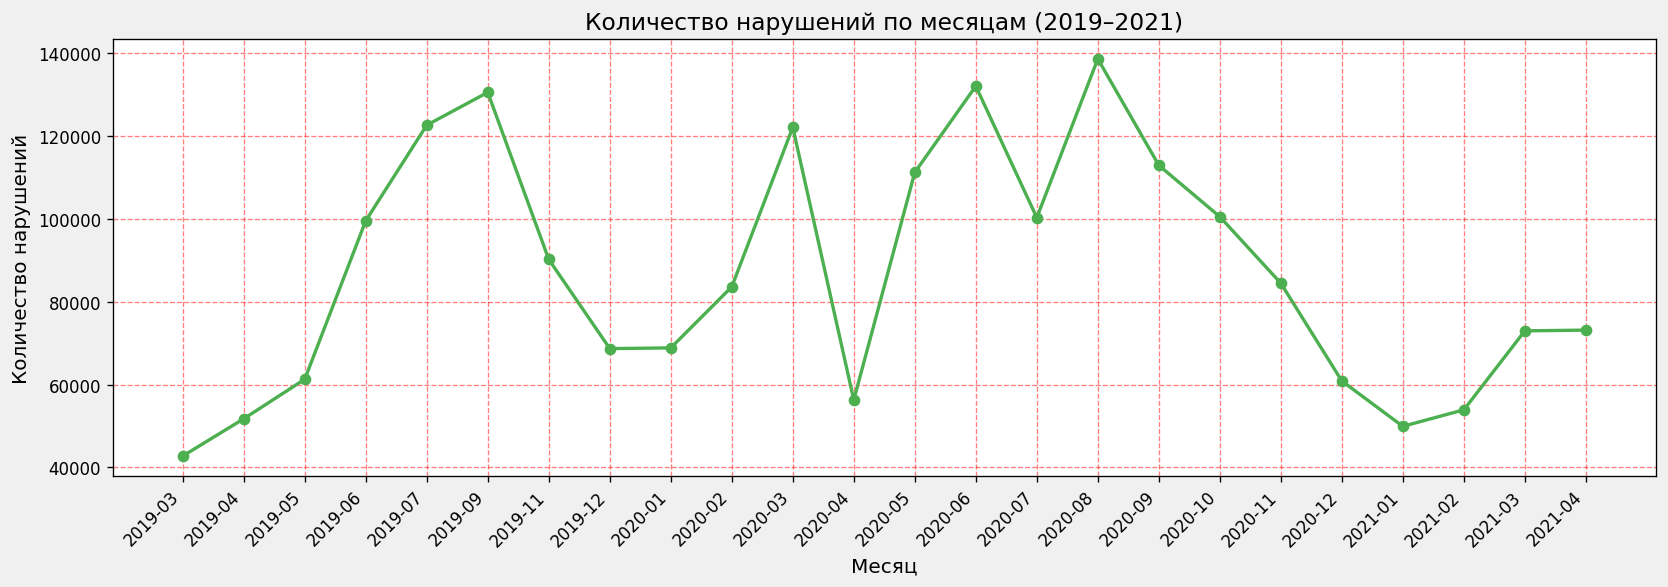

In [34]:
monthly_counts = (
    df
    .groupby(['year', 'month'])
    .size()
    .reset_index(name='n_violations')
    .sort_values(['year', 'month'])
)
monthly_counts['year_month'] = (
    monthly_counts['year'].astype(str)
    + '-'
    + monthly_counts['month'].astype(str).str.zfill(2)  
)

x = range(len(monthly_counts))
y = monthly_counts['n_violations']

fig, ax = plt.subplots(figsize=(14, 5), dpi=120)

fig.patch.set_facecolor('#f0f0f0')

ax.plot(
    x,
    y,
    marker='o',
    linewidth=2,
    color='#4caf50'                 
)

ax.grid(True, linestyle='--', alpha=0.4)

ax.set_xlabel('Месяц', fontsize=12)
ax.set_ylabel('Количество нарушений', fontsize=12)
ax.set_title('Количество нарушений по месяцам (2019–2021)', fontsize=14)

step = max(1, len(monthly_counts) // 20)

ax.set_xticks(x[::step])
ax.set_xticklabels(
    monthly_counts['year_month'].iloc[::step],
    rotation=45,
    ha='right'
)
ax.grid(True, linestyle='--', color='red', alpha=0.5)
plt.tight_layout()
plt.show()

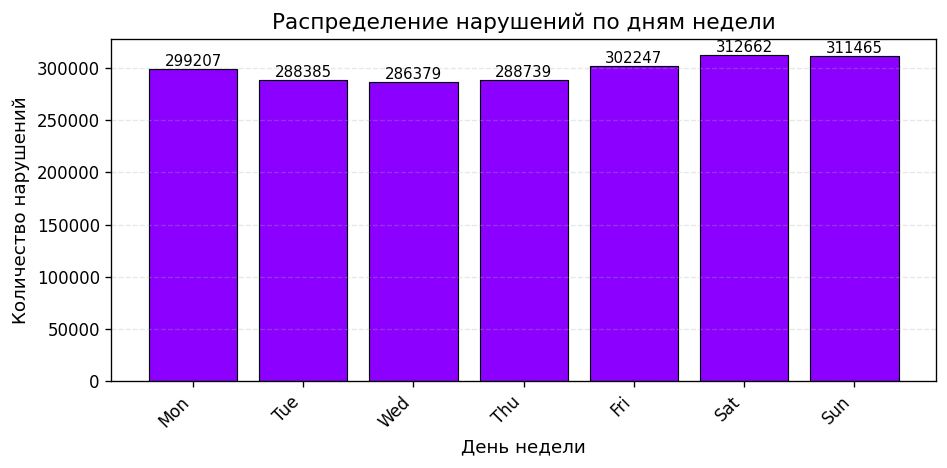

In [35]:
weekday_counts = (
    df
    .groupby(['weekday_name'])
    .size()
    .reset_index(name='n_violations')
    .sort_values('weekday_name')
)
order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

weekday_counts['weekday_name'] = pd.Categorical(
    weekday_counts['weekday_name'],
    categories=order,
    ordered=True
)

weekday_counts = weekday_counts.sort_values('weekday_name')
fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
bars = ax.bar(
    weekday_counts['weekday_name'],
    weekday_counts['n_violations'],
    color='#8B00FF',      
    edgecolor='black',    
    linewidth=0.7
)

ax.set_xlabel('День недели', fontsize=11)
ax.set_ylabel('Количество нарушений', fontsize=11)
ax.set_title('Распределение нарушений по дням недели', fontsize=13)

plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        height,                             
        f'{int(height)}',                   
        ha='center', va='bottom',          
        fontsize=9
    )

ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


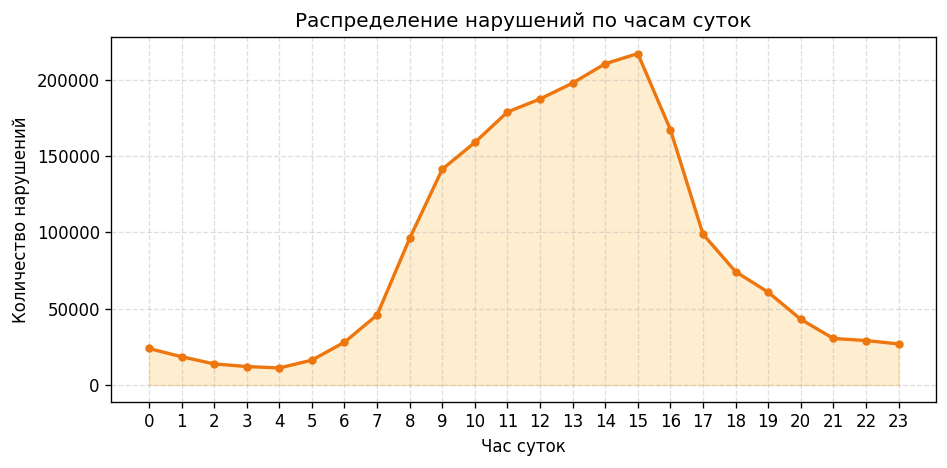

In [36]:
hour_counts = (
    df
    .groupby('hour')
    .size()
    .reset_index(name='n_violations')
    .sort_values('hour')
)

plt.figure(figsize=(8, 4), dpi=120)

x = hour_counts['hour']
y = hour_counts['n_violations']

plt.plot(x, y, marker='o', linewidth=2, color='#ED760E', markersize=4)

plt.fill_between(
    x,
    y,
    alpha=0.25,        
    color='#FFB841'    
)

plt.xlabel('Час суток')
plt.ylabel('Количество нарушений')
plt.title('Распределение нарушений по часам суток')

plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

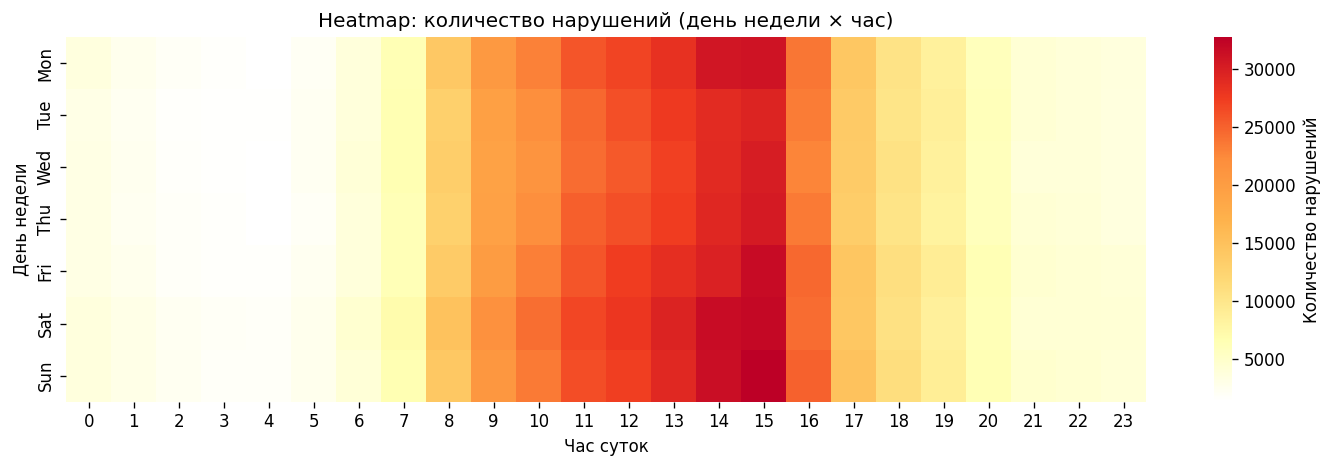

In [37]:


pivot = (
    df
    .groupby(['weekday', 'hour'])
    .size()
    .reset_index(name='n_violations')
    .pivot(index='weekday', columns='hour', values='n_violations')
    .fillna(0)
)

colors = [
    '#ffffff',
    '#ffffb2',
    '#fed976',
    '#feb24c',
    '#fd8d3c',
    '#f03b20',
    '#bd0026'
]
custom_cmap = LinearSegmentedColormap.from_list(
    'white_yellow_orange_red',
    colors
)

weekday_labels = (
    df[['weekday', 'weekday_name']]
    .drop_duplicates()
    .sort_values('weekday')['weekday_name']
    .tolist()
)

pivot_sns = pivot.copy()
pivot_sns.index = weekday_labels  

plt.figure(figsize=(12, 4), dpi=120)

sns.heatmap(
    pivot_sns,
    cmap=custom_cmap,
    cbar_kws={'label': 'Количество нарушений'} 
)

plt.xlabel('Час суток')
plt.ylabel('День недели')
plt.title('Heatmap: количество нарушений (день недели × час)')

plt.xticks(
    ticks=np.arange(0.5, 24.5),      
    labels=np.arange(0, 24)          
)

plt.tight_layout()
plt.show()


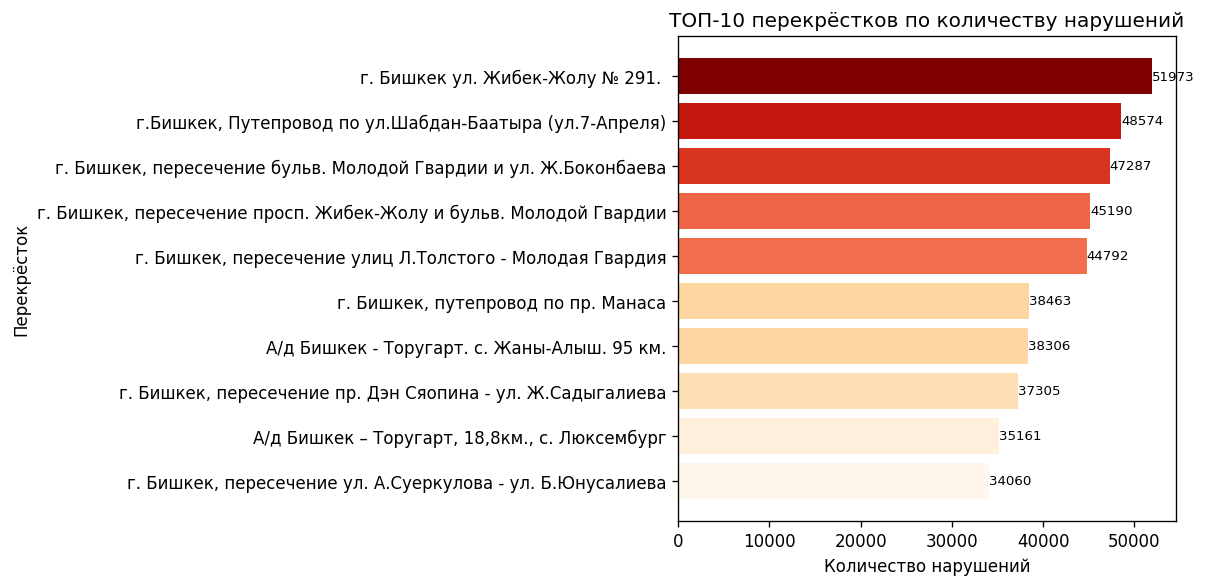

In [38]:
import matplotlib.colors as mcolors

top_crossroads = (
    df['crossroad_name']
    .value_counts()
    .head(10)
    .sort_values(ascending=True)  
)

values = top_crossroads.values

norm = mcolors.Normalize(vmin=values.min(), vmax=values.max())

cmap = plt.cm.OrRd

colors = cmap(norm(values))

plt.figure(figsize=(10, 5), dpi=120)

plt.barh(top_crossroads.index, top_crossroads.values, color=colors)

plt.xlabel('Количество нарушений')
plt.ylabel('Перекрёсток')
plt.title('ТОП-10 перекрёстков по количеству нарушений')

for i, v in enumerate(top_crossroads.values):
    plt.text(v, i, str(v), va='center', ha='left', fontsize=8)

plt.tight_layout()
plt.show()


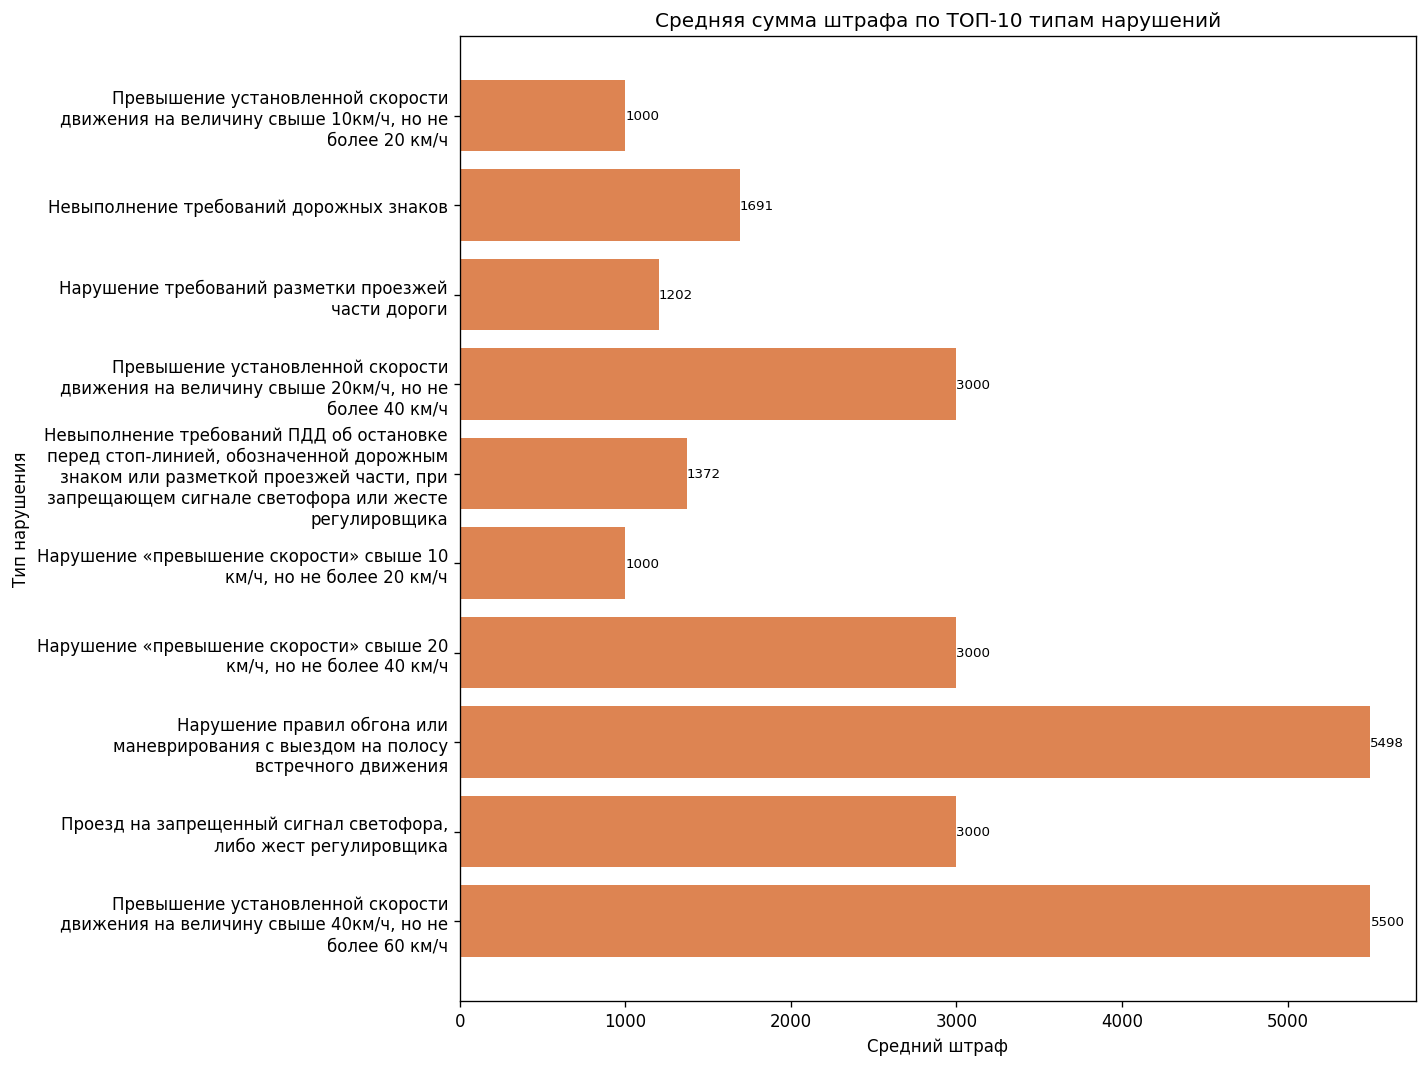

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap

top_protos_counts = (
    df['violation_protocol_name']
    .value_counts()
    .head(10)                      
    .sort_values(ascending=True)    
)

top_proto_names = top_protos_counts.index 

proto_mean_fine = (
    df[df['violation_protocol_name'].isin(top_proto_names)]
    .groupby('violation_protocol_name')['violation_ammount']
    .mean()
    .loc[top_proto_names]     
)

wrapped_labels = [textwrap.fill(name, 40) for name in proto_mean_fine.index]

plt.figure(figsize=(12, 9), dpi=120)

y_pos = np.arange(len(proto_mean_fine))

plt.barh(y_pos, proto_mean_fine.values, color='#dd8452')

plt.xlabel('Средний штраф')
plt.ylabel('Тип нарушения')
plt.title('Средняя сумма штрафа по ТОП-10 типам нарушений')

plt.yticks(y_pos, wrapped_labels)

for i, v in enumerate(proto_mean_fine.values):
    plt.text(v, i, f'{v:.0f}', va='center', ha='left', fontsize=8)

plt.tight_layout()
plt.show()

In [40]:
cross_counts = (
    df
    .groupby(['crossroad_name', 'latitude', 'longitude'])
    .size()
    .reset_index(name='n_violations')
    .sort_values('n_violations', ascending=False)
)
cross_counts


,crossroad_name,latitude,longitude,n_violations
0,г. Бишкек ул. Жибек-Жолу № 291.,42.886356,74.625874,51973
19,"г.Бишкек, Путепровод по ул.Шабдан-Баатыра (ул....",42.867031,74.636661,48574
1,"г. Бишкек, пересечение бульв. Молодой Гвардии ...",42.868335,74.575132,47287
9,"г. Бишкек, пересечение просп. Жибек-Жолу и бул...",42.884736,74.576391,45190
14,"г. Бишкек, пересечение улиц Л.Толстого - Молод...",42.866329,74.574666,44792
18,"г. Бишкек, путепровод по пр. Манаса",42.866261,74.587268,38463
3,"г. Бишкек, пересечение пр. Дэн Сяопина - ул. Ж...",42.874280,74.523351,37305
10,"г. Бишкек, пересечение ул. А.Суеркулова - ул. ...",42.835588,74.622127,34060
6,"г. Бишкек, пересечение пр. Чуй - бул. Молодой ...",42.877192,74.575236,31506
16,"г. Бишкек, пересечение улиц Чуй - Шопокова",42.875553,74.615181,30794


Общие координаты центра:
42.875426, 74.603667


In [41]:
import folium

bishkek_center = [42.875426, 74.603667]

m = folium.Map(location=bishkek_center, zoom_start=12, tiles='OpenStreetMap')

subset = cross_counts.sort_values('n_violations', ascending=False)

max_viol = subset['n_violations'].max()

for _, row in subset.iterrows():
    radius = 5 + (row['n_violations'] / max_viol) * 15

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=radius,
        color='red',
        fill=True,
        fill_opacity=0.7,
        popup=(
            f"{row['crossroad_name']}<br>"
            f"Нарушений: {row['n_violations']}"
        )
    ).add_to(m)

m 

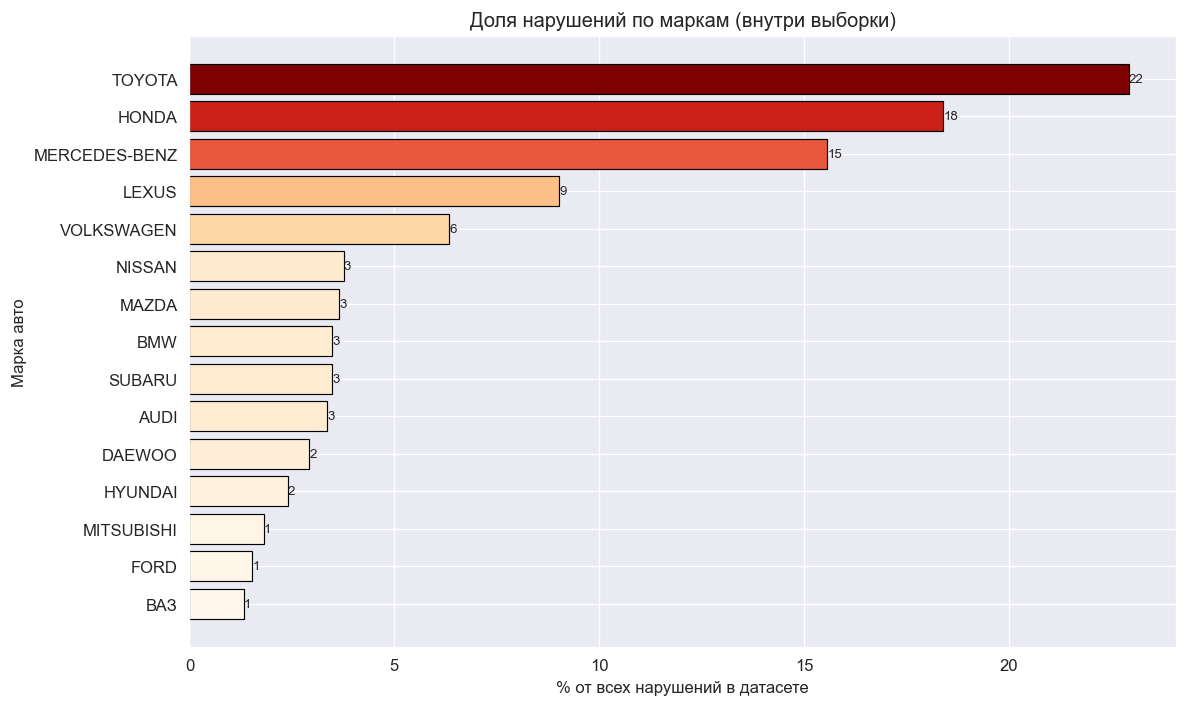

In [42]:

df['car_brand_clean'] = df['car_brand'].fillna('Unknown')

top_brands = (
    df['car_brand_clean']
    .value_counts()
    .head(15)                   
    .sort_values(ascending=True) 
)

values =  (
    top_brands / top_brands.sum()
).sort_values(ascending=True)
brands = top_brands.index

norm = mcolors.Normalize(vmin=values.min(), vmax=values.max())
cmap = plt.cm.OrRd
colors = cmap(norm(values))

fig, ax = plt.subplots(figsize=(10, 6), dpi=120)

bars = ax.barh(brands, values*100, color=colors, edgecolor='black', linewidth=0.7)

ax.set_xlabel('% от всех нарушений в датасете')
ax.set_ylabel('Марка авто')
ax.set_title('Доля нарушений по маркам (внутри выборки)')

for bar in bars:
    w = bar.get_width()
    ax.text(w, bar.get_y() + bar.get_height()/2,
            f'{int(w)}', va='center', ha='left', fontsize=8)

plt.tight_layout()
plt.show()

In [45]:
pivot = pd.crosstab(df['crossroad_name'], df['violation_protocol_name'])
agg = df.groupby('crossroad_name').agg(
    total_violations = ('violation_protocol_name','count'),
    avg_fine = ('violation_ammount','mean')
)
profile = pivot.join(agg).fillna(0)
profile = profile[profile['total_violations'] >= 10]
features = profile.drop(columns=[])
X = features.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [46]:
k = 3
km = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = km.fit_predict(X_scaled)
profile['cluster'] = labels
profile.reset_index().to_csv('crossroad_clusters.csv', index=False)

In [47]:
cluster_df = pd.read_csv('crossroad_clusters.csv')
cluster_df

,crossroad_name,"Нарушение «превышение скорости» свыше 10 км/ч, но не более 20 км/ч","Нарушение «превышение скорости» свыше 20 км/ч, но не более 40 км/ч","Нарушение «превышение скорости» свыше 40 км/ч, но не более 60 км/ч",Нарушение «превышение скорости» свыше 60 км/ч,Нарушение правил маневрирования,Нарушение правил обгона или маневрирования без выезда на полосу встречного движения,Нарушение правил обгона или маневрирования с выездом на полосу встречного движения,"Нарушение правил остановки или стоянки, в том числе остановка или стоянка на полосе для маршрутных транспортных средств",Нарушение правил остановки либо стоянки,...,"Невыполнение требований ПДД об остановке перед стоп-линией, обозначенной дорожным знаком или разметкой проезжей части, при запрещающем сигнале светофора или жесте регулировщика",Невыполнение требований дорожных знаков,Превышение установленной скорости движения на величину более 60км/ч,"Превышение установленной скорости движения на величину свыше 10км/ч, но не более 20 км/ч","Превышение установленной скорости движения на величину свыше 20км/ч, но не более 40 км/ч","Превышение установленной скорости движения на величину свыше 40км/ч, но не более 60 км/ч","Проезд на запрещенный сигнал светофора, либо жест регулировщика",total_violations,avg_fine,cluster
0,"52,00 км. Объездная а/д ""Бишкек-Нарын-Торугарт""",0,0,0,0,0,0,0,0,0,...,0,0,0,66,35,9,0,110,2004.545455,2
1,"76,00 км. Объездная, а/д ""Бишкек-Нарын-Торугарт""",0,0,0,0,0,0,0,0,0,...,0,0,0,36,7,5,0,48,1760.416667,2
2,А/д «Бишкек-Кара-Балта-Чалдовар-граница с Респ...,230,73,6,0,0,0,0,0,0,...,0,0,1,1307,256,10,0,1883,1391.131174,2
3,"А/д Биш. Торугарт, 20км., с. Люксембург",773,245,15,0,0,0,0,0,0,...,0,0,7,5223,972,32,0,7267,1370.304114,2
4,А/д Бишкек - Ош. 78км,1183,1306,113,12,0,0,0,0,0,...,0,0,11,4747,1601,118,0,9091,1770.322297,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,"г.Токмок 63,800 км. основная а/д Бишкек-Нарын-...",13,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,14,1142.857143,2
517,"г.Токмок 64,700 км. основная а/д ""Бишкек-Нарын...",149,47,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,204,1637.254902,2
518,"г.Токмок 64,900 км объездная а/д Бишкек-Нарын-...",46,22,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,69,1702.898551,2
519,"объездная, а/д ""Бишкек-Нарын-Торугарт"" - 44,30...",0,0,0,0,0,0,0,0,0,...,0,0,0,64,6,0,0,70,1171.428571,2


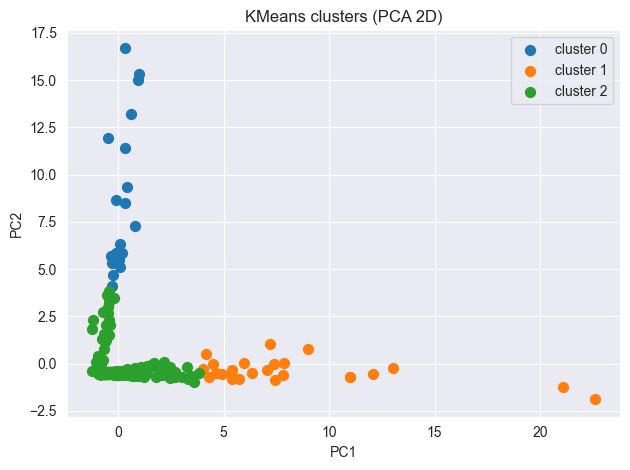


Кластер 0 - топ перекрестков по числу нарушений:


,"Нарушение «превышение скорости» свыше 10 км/ч, но не более 20 км/ч","Нарушение «превышение скорости» свыше 20 км/ч, но не более 40 км/ч","Нарушение «превышение скорости» свыше 40 км/ч, но не более 60 км/ч",Нарушение «превышение скорости» свыше 60 км/ч,Нарушение правил маневрирования,Нарушение правил обгона или маневрирования без выезда на полосу встречного движения,Нарушение правил обгона или маневрирования с выездом на полосу встречного движения,"Нарушение правил остановки или стоянки, в том числе остановка или стоянка на полосе для маршрутных транспортных средств",Нарушение правил остановки либо стоянки,"Нарушение правил проезда пешеходных переходов, движение по тротуарам",...,"Невыполнение требований ПДД об остановке перед стоп-линией, обозначенной дорожным знаком или разметкой проезжей части, при запрещающем сигнале светофора или жесте регулировщика",Невыполнение требований дорожных знаков,Превышение установленной скорости движения на величину более 60км/ч,"Превышение установленной скорости движения на величину свыше 10км/ч, но не более 20 км/ч","Превышение установленной скорости движения на величину свыше 20км/ч, но не более 40 км/ч","Превышение установленной скорости движения на величину свыше 40км/ч, но не более 60 км/ч","Проезд на запрещенный сигнал светофора, либо жест регулировщика",total_violations,avg_fine,cluster
crossroad_name,,,,,,,,,,,,,,,,,,,,,
"г. Бишкек, пересечение бульв. Молодой Гвардии и ул. Ж.Боконбаева",0,0,0,0,1269,0,10081,16,2,0,...,5570,2567,0,0,0,0,2008,47287,2205.162095,0
"г. Бишкек, пересечение просп. Жибек-Жолу и бульв. Молодой Гвардии",0,0,0,0,169,0,64,1,3,0,...,1906,35896,0,0,0,0,284,45190,1165.302058,0
"г. Бишкек, пересечение улиц Л.Толстого - Молодая Гвардия",9,0,0,0,111,1,644,0,0,0,...,31054,2184,0,80,7,0,5988,44792,1399.736560,0
"г. Бишкек, пересечение пр. Дэн Сяопина - ул. Ж.Садыгалиева",0,0,0,0,472,0,6751,1,1,0,...,4796,10626,0,0,0,0,6920,37305,2345.436269,0
"г. Бишкек, пересечение ул. А.Суеркулова - ул. Б.Юнусалиева",0,0,0,0,52,0,373,948,74,0,...,1760,5436,0,0,0,0,459,34060,1167.601292,0



Кластер 1 - топ перекрестков по числу нарушений:


,"Нарушение «превышение скорости» свыше 10 км/ч, но не более 20 км/ч","Нарушение «превышение скорости» свыше 20 км/ч, но не более 40 км/ч","Нарушение «превышение скорости» свыше 40 км/ч, но не более 60 км/ч",Нарушение «превышение скорости» свыше 60 км/ч,Нарушение правил маневрирования,Нарушение правил обгона или маневрирования без выезда на полосу встречного движения,Нарушение правил обгона или маневрирования с выездом на полосу встречного движения,"Нарушение правил остановки или стоянки, в том числе остановка или стоянка на полосе для маршрутных транспортных средств",Нарушение правил остановки либо стоянки,"Нарушение правил проезда пешеходных переходов, движение по тротуарам",...,"Невыполнение требований ПДД об остановке перед стоп-линией, обозначенной дорожным знаком или разметкой проезжей части, при запрещающем сигнале светофора или жесте регулировщика",Невыполнение требований дорожных знаков,Превышение установленной скорости движения на величину более 60км/ч,"Превышение установленной скорости движения на величину свыше 10км/ч, но не более 20 км/ч","Превышение установленной скорости движения на величину свыше 20км/ч, но не более 40 км/ч","Превышение установленной скорости движения на величину свыше 40км/ч, но не более 60 км/ч","Проезд на запрещенный сигнал светофора, либо жест регулировщика",total_violations,avg_fine,cluster
crossroad_name,,,,,,,,,,,,,,,,,,,,,
г. Бишкек ул. Жибек-Жолу № 291.,0,0,0,0,0,0,0,0,0,0,...,0,0,4,43150,8667,152,0,51973,1347.180267,1
"г.Бишкек, Путепровод по ул.Шабдан-Баатыра (ул.7-Апреля)",0,0,0,0,0,0,0,0,0,0,...,0,0,109,42405,5628,432,0,48574,1286.336312,1
"г. Бишкек, путепровод по пр. Манаса",7863,8608,678,104,0,0,0,0,0,0,...,0,2,32,18666,2355,155,0,38463,1690.598757,1
А/д Бишкек - Торугарт. с. Жаны-Алыш. 95 км.,4563,3536,406,52,0,0,0,0,0,0,...,0,0,205,19505,8902,1137,0,38306,1874.275570,1
"А/д Бишкек – Торугарт, 18,8км., с. Люксембург",6792,1264,70,6,0,0,0,0,0,0,...,0,0,19,23129,3695,186,0,35161,1319.459060,1



Кластер 2 - топ перекрестков по числу нарушений:


,"Нарушение «превышение скорости» свыше 10 км/ч, но не более 20 км/ч","Нарушение «превышение скорости» свыше 20 км/ч, но не более 40 км/ч","Нарушение «превышение скорости» свыше 40 км/ч, но не более 60 км/ч",Нарушение «превышение скорости» свыше 60 км/ч,Нарушение правил маневрирования,Нарушение правил обгона или маневрирования без выезда на полосу встречного движения,Нарушение правил обгона или маневрирования с выездом на полосу встречного движения,"Нарушение правил остановки или стоянки, в том числе остановка или стоянка на полосе для маршрутных транспортных средств",Нарушение правил остановки либо стоянки,"Нарушение правил проезда пешеходных переходов, движение по тротуарам",...,"Невыполнение требований ПДД об остановке перед стоп-линией, обозначенной дорожным знаком или разметкой проезжей части, при запрещающем сигнале светофора или жесте регулировщика",Невыполнение требований дорожных знаков,Превышение установленной скорости движения на величину более 60км/ч,"Превышение установленной скорости движения на величину свыше 10км/ч, но не более 20 км/ч","Превышение установленной скорости движения на величину свыше 20км/ч, но не более 40 км/ч","Превышение установленной скорости движения на величину свыше 40км/ч, но не более 60 км/ч","Проезд на запрещенный сигнал светофора, либо жест регулировщика",total_violations,avg_fine,cluster
crossroad_name,,,,,,,,,,,,,,,,,,,,,
г. Бишкек ул. Жибек-Жолу № 291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,17661,2962,51,0,20674,1297.644384,2
"г. Бишкек, пересечение пр. Жибек Жолу – ул. Курманжан Датки",0,0,0,0,146,0,34,0,14,0,...,2093,13057,0,0,0,0,259,18874,1513.457667,2
"г. Бишкек, ул. Жибек-Жолу дом № 291",0,0,0,0,0,0,0,0,0,0,...,0,0,0,14997,2494,41,0,17532,1295.031942,2
"Аламудунский р-он. с. Аламудун ул. Алма-Атинская № 472, а/д ""Бишкек-Кордай"" - 9,00 км.",0,0,0,0,0,0,0,0,0,0,...,0,0,10,13619,3171,128,0,16928,1412.511815,2
"г. Бишкек, пересечение улиц Жибек Жолу - Абдрахманова",0,0,0,0,0,0,13,0,2,0,...,671,15227,0,0,0,0,19,16035,3002.026816,2


In [50]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
for cl in sorted(np.unique(labels)):
    idx = labels == cl
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=f'cluster {cl}', s=50)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('KMeans clusters (PCA 2D)')
plt.legend(); plt.tight_layout(); plt.show()
for cl in sorted(profile['cluster'].unique()):
    print(f"\nКластер {cl} - топ перекрестков по числу нарушений:")
    display(profile[profile['cluster']==cl].sort_values('total_violations', ascending=False).head(5))

In [58]:
features = [
    'car_brand',
    'car_model',
    'crossroad_name',
    'violation_protocol_name',
    'hour',
    'weekday',
    'month'
]
target = 'violation_ammount'
X = df[features]
y = df[target]

categorical = ['car_brand', 'car_model', 'crossroad_name',
               'violation_protocol_name', 'weekday']
numeric = ['hour', 'month']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', 'passthrough', numeric)
    ]
)
model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('regressor', Ridge(alpha=1.0))
])

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
y_train

493110     1000
1626195    1000
1551940    1000
410895     1000
1038857    1000
           ... 
259178     1000
1414414    1000
131932     1000
671155     3000
121958     1000
Name: violation_ammount, Length: 1566813, dtype: int64

In [60]:
model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [61]:
y_pred = model.predict(X_test)

In [63]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Regression results:")
print(f"MAE: {mae:.2f}")
print(f"R^2: {r2:.3f}")

Regression results:
MAE: 126.36
R^2: 0.919
